https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/

- model & application：密不可分，都十分必要
- `LangChain`/`LangGraph`：提供了很多脚手架和工具，适当上手之后，会极大的简化开发；
    - 虽然目前我只选择这两个工具，很多设计是可以复用的，可以很快地切到其他的 LLM dev framework；
    - 入门和上手：不断的消化基本概念、基本设计，我觉得是非常必要的，相当大的比例是跟 openai api 对齐的（function calling）以及最新的 llm 的科研论文；
- Structured output：而非自然语言，而希望达到 100%，出于自动化的目的；
    - 基础是 function calling，response model as a tool
    - llm 结果评估，整个 workflow/pipeline 中间环节的一部分
        - 避免很多字符串繁琐的基于正则的解析
    - llm 合成数据
    - 基于 llm 对原始的非结构化数据做结构化的提取

In [1]:
# !pip install -U langchain
# !pip install -U langchain-openai
# !pip install -U langgraph
# !pip install -U openai

In [2]:
from IPython.display import Image

In [3]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

In [4]:
from dotenv import load_dotenv
assert load_dotenv()

In [5]:
class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(description="The direction of the wind in abbreviated form")
    wind_speed: float = Field(description="The speed of the wind in km/h")

In [6]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages 
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

In [7]:
from typing import get_type_hints

In [8]:
# messages：chat history，append
# final_response: 
get_type_hints(AgentState)

{'messages': list[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage, langchain_core.messages.ai.AIMessageChunk, langchain_core.messages.human.HumanMessageChunk, langchain_core.messages.chat.ChatMessageChunk, langchain_core.messages.system.SystemMessageChunk, langchain_core.messages.function.FunctionMessageChunk, langchain_core.messages.tool.ToolMessageChunk]],
 'final_response': __main__.WeatherResponse}

In [9]:
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")

In [10]:
tools = [get_weather]

In [11]:
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [12]:
model_w_output = llm.with_structured_output(WeatherResponse)

In [13]:
model_w_output.invoke("what's the weather in SF?")

WeatherResponse(temperature=65.0, wind_directon='NW', wind_speed=15.0)

In [14]:
# update langchain-openai 等
model_w_output = llm.with_structured_output(WeatherResponse, strict=True)

In [15]:
model_w_output.invoke("what's the weather in SF?")

WeatherResponse(temperature=60.0, wind_directon='NW', wind_speed=15.0)

In [16]:
model_w_output.invoke(('Human', "what's the weather in SF?"))

WeatherResponse(temperature=65.0, wind_directon='NW', wind_speed=10.0)

In [17]:
Image(url='./imgs/structure_output_option1.png', width=500)

In [18]:
Image(url='./imgs/structure_output_option2.png', width=500)

In [19]:
Image(url='./imgs/react-output.png', width=500)

- ReAct agent
    - a model node and a tool-calling node
- 增加一个 respond 节点，做结构化的输出处理；

### Option 1: Bind output as tool¶

In [20]:
Image(url='./imgs/structure_output_option1.png', width=500)

- only one `LLM`
- setting `tool_choice` to `any` when we use `bind_tools` which forces the LLM to select at least one tool at every turn, but this is far from a fool proof strategy. 

In [21]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# pydantic model as a tool
tools = [get_weather, WeatherResponse]

In [23]:
# Force the model to use tools by passing tool_choice="any"    
model_with_resp_tool = llm.bind_tools(tools, tool_choice="any")

In [24]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_resp_tool.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [25]:
# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    response = WeatherResponse(**state['messages'][-1].tool_calls[0]['args'])
    # We return the final answer
    return {"final_response": response}

In [26]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if len(last_message.tool_calls) == 1 and last_message.tool_calls[0]['name'] == "WeatherResponse":
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"

In [27]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

In [28]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

In [29]:
graph.get_graph().edges

[Edge(source='__start__', target='agent', data=None, conditional=False),
 Edge(source='respond', target='__end__', data=None, conditional=False),
 Edge(source='tools', target='agent', data=None, conditional=False),
 Edge(source='agent', target='tools', data='continue', conditional=True),
 Edge(source='agent', target='respond', data=None, conditional=True)]

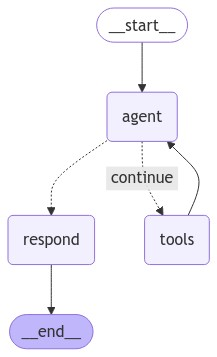

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
# states
results = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})

In [32]:
from rich.pretty import pprint
pprint(results)

{
│   'messages': [
│   │   HumanMessage(
│   │   │   content="what's the weather in SF?",
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   id='be07a97c-33bb-4603-bf5e-35b0acad09c8'
│   │   ),
│   │   AIMessage(
│   │   │   content='',
│   │   │   additional_kwargs={
│   │   │   │   'tool_calls': [
│   │   │   │   │   {
│   │   │   │   │   │   'id': 'call_n7Lp6RmyrMrLVi3KKSeM3nI8',
│   │   │   │   │   │   'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'},
│   │   │   │   │   │   'type': 'function'
│   │   │   │   │   }
│   │   │   │   ],
│   │   │   │   'refusal': None
│   │   │   },
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 12,
│   │   │   │   │   'prompt_tokens': 122,
│   │   │   │   │   'total_tokens': 134,
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-3.5-turbo-0125',
│   │   │   │   'system_fingerprint': None,
│   │   │   │   'finish_reason': 'stop',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-cab85c22-7942-42b8-bbf5-7de4f1f2620c-0',
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_weather',
│   │   │   │   │   'args': {'city': 'sf'},
│   │   │   │   │   'id': 'call_n7Lp6RmyrMrLVi3KKSeM3nI8',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ],
│   │   │   usage_metadata={'input_tokens': 122, 'output_tokens': 12, 'total_tokens': 134}
│   │   ),
│   │   ToolMessage(
│   │   │   content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction',
│   │   │   name='get_weather',
│   │   │   id='74038e8c-0a5f-42f2-b7d9-b01902254927',
│   │   │   tool_call_id='call_n7Lp6RmyrMrLVi3KKSeM3nI8'
│   │   ),
│   │   AIMessage(
│   │   │   content='',
│   │   │   additional_kwargs={
│   │   │   │   'tool_calls': [
│   │   │   │   │   {
│   │   │   │   │   │   'id': 'call_v31rik0EQKhhQFyucrHCO0qg',
│   │   │   │   │   │   'function': {
│   │   │   │   │   │   │   'arguments': '{"temperature":75,"wind_directon":"SE","wind_speed":3}',
│   │   │   │   │   │   │   'name': 'WeatherResponse'
│   │   │   │   │   │   },
│   │   │   │   │   │   'type': 'function'
│   │   │   │   │   }
│   │   │   │   ],
│   │   │   │   'refusal': None
│   │   │   },
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 24,
│   │   │   │   │   'prompt_tokens': 164,
│   │   │   │   │   'total_tokens': 188,
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-3.5-turbo-0125',
│   │   │   │   'system_fingerprint': None,
│   │   │   │   'finish_reason': 'stop',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-476ed669-9634-4577-898f-286bb7886bce-0',
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'WeatherResponse',
│   │   │   │   │   'args': {'temperature': 75, 'wind_directon': 'SE', 'wind_speed': 3},
│   │   │   │   │   'id': 'call_v31rik0EQKhhQFyucrHCO0qg',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ],
│   │   │   usage_metadata={'input_tokens': 164, 'output_tokens': 24, 'total_tokens': 188}
│   │   )
│   ],
│   'final_response': WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)
}

In [33]:
results['messages'][-1].tool_calls

[{'name': 'WeatherResponse',
  'args': {'temperature': 75, 'wind_directon': 'SE', 'wind_speed': 3},
  'id': 'call_v31rik0EQKhhQFyucrHCO0qg',
  'type': 'tool_call'}]

In [34]:
results['messages'][0]

HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='be07a97c-33bb-4603-bf5e-35b0acad09c8')

In [35]:
results['messages'][1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n7Lp6RmyrMrLVi3KKSeM3nI8', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 122, 'total_tokens': 134, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-cab85c22-7942-42b8-bbf5-7de4f1f2620c-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_n7Lp6RmyrMrLVi3KKSeM3nI8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 122, 'output_tokens': 12, 'total_tokens': 134})

In [36]:
results['messages'][1].additional_kwargs['tool_calls']

[{'id': 'call_n7Lp6RmyrMrLVi3KKSeM3nI8',
  'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'},
  'type': 'function'}]

In [37]:
results['messages'][2]

ToolMessage(content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction', name='get_weather', id='74038e8c-0a5f-42f2-b7d9-b01902254927', tool_call_id='call_n7Lp6RmyrMrLVi3KKSeM3nI8')

In [38]:
results['messages'][3]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v31rik0EQKhhQFyucrHCO0qg', 'function': {'arguments': '{"temperature":75,"wind_directon":"SE","wind_speed":3}', 'name': 'WeatherResponse'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 164, 'total_tokens': 188, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-476ed669-9634-4577-898f-286bb7886bce-0', tool_calls=[{'name': 'WeatherResponse', 'args': {'temperature': 75, 'wind_directon': 'SE', 'wind_speed': 3}, 'id': 'call_v31rik0EQKhhQFyucrHCO0qg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 164, 'output_tokens': 24, 'total_tokens': 188})

### Option 2: 2 LLMs¶

In [39]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

tools = [get_weather]
llm_with_tools = llm.bind_tools(tools)
llm_with_structured_output = llm.with_structured_output(WeatherResponse, strict=True)

In [40]:
# Define the function that calls the model
def call_model(state: AgentState):
    response = llm_with_tools.invoke(state['messages'])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [41]:
# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = llm_with_structured_output.invoke([HumanMessage(content=state['messages'][-2].content)])
    # We return the final answer
    return {"final_response": response}

In [42]:
# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [43]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()


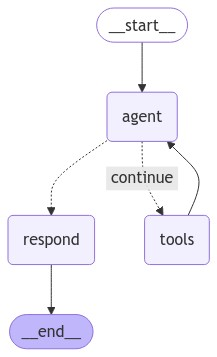

In [44]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [45]:
results = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})

In [46]:
from rich.pretty import pprint
pprint(results)

{
│   'messages': [
│   │   HumanMessage(
│   │   │   content="what's the weather in SF?",
│   │   │   additional_kwargs={},
│   │   │   response_metadata={},
│   │   │   id='8912de4b-fb1d-42cb-9ac0-78e36e9550a3'
│   │   ),
│   │   AIMessage(
│   │   │   content='',
│   │   │   additional_kwargs={
│   │   │   │   'tool_calls': [
│   │   │   │   │   {
│   │   │   │   │   │   'id': 'call_4p8mre75woEdOWCuKYMcCeYV',
│   │   │   │   │   │   'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'},
│   │   │   │   │   │   'type': 'function'
│   │   │   │   │   }
│   │   │   │   ],
│   │   │   │   'refusal': None
│   │   │   },
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 14,
│   │   │   │   │   'prompt_tokens': 59,
│   │   │   │   │   'total_tokens': 73,
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-3.5-turbo-0125',
│   │   │   │   'system_fingerprint': None,
│   │   │   │   'finish_reason': 'tool_calls',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-5c25a00c-8179-40df-85b9-00b0851b80b7-0',
│   │   │   tool_calls=[
│   │   │   │   {
│   │   │   │   │   'name': 'get_weather',
│   │   │   │   │   'args': {'city': 'sf'},
│   │   │   │   │   'id': 'call_4p8mre75woEdOWCuKYMcCeYV',
│   │   │   │   │   'type': 'tool_call'
│   │   │   │   }
│   │   │   ],
│   │   │   usage_metadata={'input_tokens': 59, 'output_tokens': 14, 'total_tokens': 73}
│   │   ),
│   │   ToolMessage(
│   │   │   content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction',
│   │   │   name='get_weather',
│   │   │   id='5e0140fb-cb35-40d6-8390-80fcbc5d5bd7',
│   │   │   tool_call_id='call_4p8mre75woEdOWCuKYMcCeYV'
│   │   ),
│   │   AIMessage(
│   │   │   content='The weather in San Francisco is currently 75 degrees and sunny, with 3 mph winds in the South-East direction.',
│   │   │   additional_kwargs={'refusal': None},
│   │   │   response_metadata={
│   │   │   │   'token_usage': {
│   │   │   │   │   'completion_tokens': 25,
│   │   │   │   │   'prompt_tokens': 101,
│   │   │   │   │   'total_tokens': 126,
│   │   │   │   │   'completion_tokens_details': {'reasoning_tokens': 0}
│   │   │   │   },
│   │   │   │   'model_name': 'gpt-3.5-turbo-0125',
│   │   │   │   'system_fingerprint': None,
│   │   │   │   'finish_reason': 'stop',
│   │   │   │   'logprobs': None
│   │   │   },
│   │   │   id='run-10882c55-1f62-4267-ae72-419cf2001ff0-0',
│   │   │   usage_metadata={'input_tokens': 101, 'output_tokens': 25, 'total_tokens': 126}
│   │   )
│   ],
│   'final_response': WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.8)
}

In [47]:
results['final_response']

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=4.8)

In [48]:
results

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='8912de4b-fb1d-42cb-9ac0-78e36e9550a3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4p8mre75woEdOWCuKYMcCeYV', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 59, 'total_tokens': 73, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5c25a00c-8179-40df-85b9-00b0851b80b7-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_4p8mre75woEdOWCuKYMcCeYV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 14, 'total_tokens': 73}),
  ToolMessage(content='It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction', name='get_weather',

### `strict=True`

- openai official：https://openai.com/index/introducing-structured-outputs-in-the-api/
    - August 6, 2024
    - gpt-4o-2024-08-06
    - https://platform.openai.com/docs/guides/structured-outputs
- langchain 兼容
    - https://api.python.langchain.com/en/latest/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html
    - `llm.bind_tools([GetWeather, GetPopulation], strict=True)`
        -  enforce tool args schema is respected
    -  `llm.with_structured_output(Response, strict=True)`

In [49]:
from enum import Enum
from typing import Union

from pydantic import BaseModel

import openai
from openai import OpenAI

In [50]:
class Table(str, Enum):
    orders = "orders"
    customers = "customers"
    products = "products"

class Column(str, Enum):
    id = "id"
    status = "status"
    expected_delivery_date = "expected_delivery_date"
    delivered_at = "delivered_at"
    shipped_at = "shipped_at"
    ordered_at = "ordered_at"
    canceled_at = "canceled_at"

class Operator(str, Enum):
    eq = "="
    gt = ">"
    lt = "<"
    le = "<="
    ge = ">="
    ne = "!="

class OrderBy(str, Enum):
    asc = "asc"
    desc = "desc"

class DynamicValue(BaseModel):
    column_name: str

class Condition(BaseModel):
    column: str
    operator: Operator
    value: Union[str, int, DynamicValue]

class Query(BaseModel):
    table_name: Table
    columns: list[Column]
    conditions: list[Condition]
    order_by: OrderBy

In [51]:
client = OpenAI()

completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant. The current date is August 6, 2024. You help users query for the data they are looking for by calling the query function.",
        },
        {
            "role": "user",
            "content": "look up all my orders in may of last year that were fulfilled but not delivered on time",
        },
    ],
    tools=[
        # model as a tool
        openai.pydantic_function_tool(Query),
    ],
)

In [52]:
from rich.pretty import pprint
pprint(completion)

ParsedChatCompletion[NoneType](
│   id='chatcmpl-ADNUx3Kglgje8egztzsq1BpFCxhA8',
│   choices=[
│   │   ParsedChoice[NoneType](
│   │   │   finish_reason='tool_calls',
│   │   │   index=0,
│   │   │   logprobs=None,
│   │   │   message=ParsedChatCompletionMessage[NoneType](
│   │   │   │   content=None,
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=[
│   │   │   │   │   ParsedFunctionToolCall(
│   │   │   │   │   │   id='call_1Kzkp6sUwGkXnjj8H2TV8c8h',
│   │   │   │   │   │   function=ParsedFunction(
│   │   │   │   │   │   │   arguments='{"table_name":"orders","columns":["id","status","expected_delivery_date","delivered_at"],"conditions":[{"column":"status","operator":"=","value":"fulfilled"},{"column":"ordered_at","operator":"<=","value":"2023-05-31"},{"column":"ordered_at","operator":">=","value":"2023-05-01"},{"column":"expected_delivery_date","operator":"<","value":{"column_name":"delivered_at"}}],"order_by":"asc"}',
│   │   │   │   │   │   │   name='Query',
│   │   │   │   │   │   │   parsed_arguments=Query(
│   │   │   │   │   │   │   │   table_name=<Table.orders: 'orders'>,
│   │   │   │   │   │   │   │   columns=[
│   │   │   │   │   │   │   │   │   <Column.id: 'id'>,
│   │   │   │   │   │   │   │   │   <Column.status: 'status'>,
│   │   │   │   │   │   │   │   │   <Column.expected_delivery_date: 'expected_delivery_date'>,
│   │   │   │   │   │   │   │   │   <Column.delivered_at: 'delivered_at'>
│   │   │   │   │   │   │   │   ],
│   │   │   │   │   │   │   │   conditions=[
│   │   │   │   │   │   │   │   │   Condition(column='status', operator=<Operator.eq: '='>, value='fulfilled'),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='ordered_at',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.le: '<='>,
│   │   │   │   │   │   │   │   │   │   value='2023-05-31'
│   │   │   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='ordered_at',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.ge: '>='>,
│   │   │   │   │   │   │   │   │   │   value='2023-05-01'
│   │   │   │   │   │   │   │   │   ),
│   │   │   │   │   │   │   │   │   Condition(
│   │   │   │   │   │   │   │   │   │   column='expected_delivery_date',
│   │   │   │   │   │   │   │   │   │   operator=<Operator.lt: '<'>,
│   │   │   │   │   │   │   │   │   │   value=DynamicValue(column_name='delivered_at')
│   │   │   │   │   │   │   │   │   )
│   │   │   │   │   │   │   │   ],
│   │   │   │   │   │   │   │   order_by=<OrderBy.asc: 'asc'>
│   │   │   │   │   │   │   )
│   │   │   │   │   │   ),
│   │   │   │   │   │   type='function'
│   │   │   │   │   )
│   │   │   │   ],
│   │   │   │   parsed=None
│   │   │   )
│   │   )
│   ],
│   created=1727751955,
│   model='gpt-4o-2024-08-06',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint='fp_e5e4913e83',
│   usage=CompletionUsage(
│   │   completion_tokens=107,
│   │   prompt_tokens=230,
│   │   total_tokens=337,
│   │   completion_tokens_details={'reasoning_tokens': 0}
│   )
)

In [53]:
completion.choices[0].message.tool_calls[0].function.parsed_arguments

Query(table_name=<Table.orders: 'orders'>, columns=[<Column.id: 'id'>, <Column.status: 'status'>, <Column.expected_delivery_date: 'expected_delivery_date'>, <Column.delivered_at: 'delivered_at'>], conditions=[Condition(column='status', operator=<Operator.eq: '='>, value='fulfilled'), Condition(column='ordered_at', operator=<Operator.le: '<='>, value='2023-05-31'), Condition(column='ordered_at', operator=<Operator.ge: '>='>, value='2023-05-01'), Condition(column='expected_delivery_date', operator=<Operator.lt: '<'>, value=DynamicValue(column_name='delivered_at'))], order_by=<OrderBy.asc: 'asc'>)

#### case 2

In [54]:
class Step(BaseModel):
    explanation: str
    output: str

class MathResponse(BaseModel):
    steps: list[Step]
    final_answer: str

In [55]:
client = OpenAI()

completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": "You are a helpful math tutor."},
        {"role": "user", "content": "solve 8x + 31 = 2"},
    ],
    response_format=MathResponse,
)

In [56]:
pprint(completion)

ParsedChatCompletion[MathResponse](
│   id='chatcmpl-ADNVBpHPXi5RyEuWTjswIM09xw64M',
│   choices=[
│   │   ParsedChoice[MathResponse](
│   │   │   finish_reason='stop',
│   │   │   index=0,
│   │   │   logprobs=None,
│   │   │   message=ParsedChatCompletionMessage[MathResponse](
│   │   │   │   content='{"steps":[{"explanation":"First, we need to isolate the term with the variable on one side of the equation. We\'ll start by subtracting 31 from both sides of the equation.","output":"8x + 31 - 31 = 2 - 31"},{"explanation":"After subtracting 31 from both sides, we simplify the equation.","output":"8x = -29"},{"explanation":"Next, to solve for x, we divide both sides of the equation by 8.","output":"x = -29 / 8"},{"explanation":"Simplify the fraction to express the final result.","output":"x = -3.625"}],"final_answer":"x = -3.625"}',
│   │   │   │   refusal=None,
│   │   │   │   role='assistant',
│   │   │   │   function_call=None,
│   │   │   │   tool_calls=[],
│   │   │   │   parsed=MathResponse(
│   │   │   │   │   steps=[
│   │   │   │   │   │   Step(
│   │   │   │   │   │   │   explanation="First, we need to isolate the term with the variable on one side of the equation. We'll start by subtracting 31 from both sides of the equation.",
│   │   │   │   │   │   │   output='8x + 31 - 31 = 2 - 31'
│   │   │   │   │   │   ),
│   │   │   │   │   │   Step(
│   │   │   │   │   │   │   explanation='After subtracting 31 from both sides, we simplify the equation.',
│   │   │   │   │   │   │   output='8x = -29'
│   │   │   │   │   │   ),
│   │   │   │   │   │   Step(
│   │   │   │   │   │   │   explanation='Next, to solve for x, we divide both sides of the equation by 8.',
│   │   │   │   │   │   │   output='x = -29 / 8'
│   │   │   │   │   │   ),
│   │   │   │   │   │   Step(
│   │   │   │   │   │   │   explanation='Simplify the fraction to express the final result.',
│   │   │   │   │   │   │   output='x = -3.625'
│   │   │   │   │   │   )
│   │   │   │   │   ],
│   │   │   │   │   final_answer='x = -3.625'
│   │   │   │   )
│   │   │   )
│   │   )
│   ],
│   created=1727751969,
│   model='gpt-4o-2024-08-06',
│   object='chat.completion',
│   service_tier=None,
│   system_fingerprint='fp_e5e4913e83',
│   usage=CompletionUsage(
│   │   completion_tokens=145,
│   │   prompt_tokens=127,
│   │   total_tokens=272,
│   │   completion_tokens_details={'reasoning_tokens': 0}
│   )
)

In [57]:
message = completion.choices[0].message
if message.parsed:
    print(message.parsed.steps)
    print(message.parsed.final_answer)
else:
    print(message.refusal)

[Step(explanation="First, we need to isolate the term with the variable on one side of the equation. We'll start by subtracting 31 from both sides of the equation.", output='8x + 31 - 31 = 2 - 31'), Step(explanation='After subtracting 31 from both sides, we simplify the equation.', output='8x = -29'), Step(explanation='Next, to solve for x, we divide both sides of the equation by 8.', output='x = -29 / 8'), Step(explanation='Simplify the fraction to express the final result.', output='x = -3.625')]
x = -3.625
